# Introduction

New York City (NYC), often called The City or simply New York (NY), is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities.

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. 

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world.

With various ethic groups residing together, there are businesses small and large owned by them too. This project focuses on ‘Indian Restaurants’ in NYC. 

Source - Wikipedia


# Data

1.	List of Boroughs, Neighborhoods with latitudes and longitudes
•	Source - https://cocl.us/new_york_dataset
•	Description - A data frame with information is created using the data set. Longitudes and latitudes are obtained using geopy.

2.	Indian restaurants in NYC
•	Source – Foursquare API
•	Description – Indian restaurants will be filtered out from venue data obtained via Foursqaure. Further information like rating and tips are used for analysis in later stages. Specific restaurants will be mapped using folium.


# Outline of analysis

1.	Obtain and filter relevant NYC data from https://cocl.us/new_york_dataset
2.	Obtain venues in each neighbourhood using Foursquare
3.	Filter Indian restaurants
4.	Obtain rating, tips and other parameters for said restaurants
5.	Rank restaurants using data
6.	Visualize ranked data using Folium


# Analysis

Import libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
#from bs4 import BeautifulSoup
#import geocoder
import os
import folium # map rendering library
!pip install geopy
from geopy.geocoders import Nominatim#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Defining function to obtain New York City data

In [2]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Defining function to obtain Venues information in NYC Neighborhoods from Foursquare

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Defining function to obtain ranking data (Likes, rating, tips) from Foursquare (Premium calls)

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Calling function to get NYC data

In [5]:
new_york_data=get_new_york_data()


In [6]:
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


On multiple attempts, timeouts on the Foursquare API was noticed. Splitting data to avoid timeout in subsequent actions

In [7]:
new_york_data1=new_york_data.iloc[:75]
new_york_data2=new_york_data.iloc[75:150]
new_york_data3=new_york_data.iloc[150:225]
new_york_data4=new_york_data.iloc[225:]

Get 'Indian restaurants' for neighborhoods 1-75

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny1=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data1.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data1),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny1 = indian_rest_ny1.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_ny1.head()

Get 'Indian restaurants' for neighborhoods 75-150

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny2=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data2.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data2),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny2 = indian_rest_ny2.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_ny2.head()

Get 'Indian restaurants' for neighborhoods 150-225

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny3=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data3.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data3),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny3 = indian_rest_ny3.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_ny3.head()

Get remaining 'Indian Restaurant' data

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny4=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data4.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data4),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny4 = indian_rest_ny4.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_ny4.head()

Concatenate files and save

In [ ]:
files=[indian_rest_ny1,indian_rest_ny2,indian_rest_ny3,indian_rest_ny4]
indian_rest_ny=pd.concat(files)

In [ ]:
indian_rest_ny.shape

In [ ]:
indian_rest_ny.to_csv('indian_rest_ny.csv', index=False)


Read 'Indian Restaurant' data

In [8]:
indian_rest_ny=pd.read_csv('indian_rest_ny.csv')
indian_rest_ny.shape
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


We have 145 Indian restaurants in NYC. Lets visualize restaurants in boroughs (top 5)

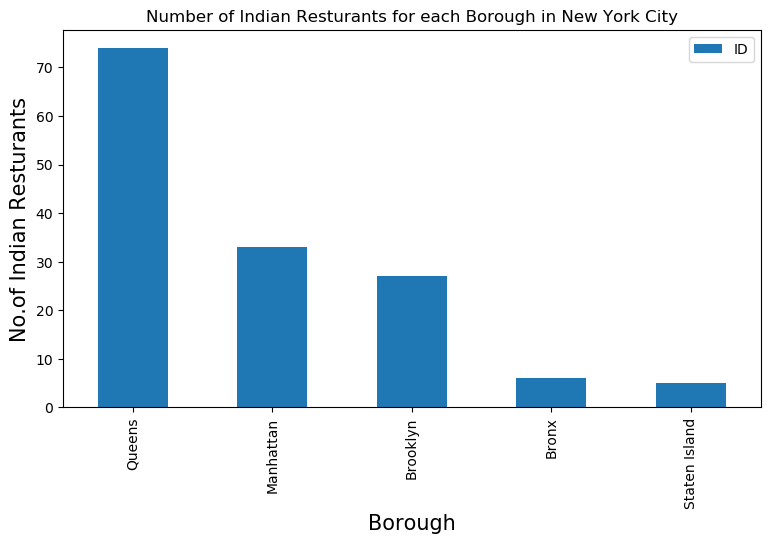

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We now obtain ranking data (Likes, Ratings, Tips) for each restaurant. This data is obtained from Premium calls to Foursquare. Splitting data to avoid timeout/other issues

In [10]:
indian_rest_ny1=indian_rest_ny.iloc[:50]
indian_rest_ny2=indian_rest_ny.iloc[50:100]
indian_rest_ny3=indian_rest_ny.iloc[100:]

In [11]:
indian_rest_ny3.shape

(45, 4)

Process 'Indian Restaurant' data 1-50

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny1=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny1.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny1),')','processed')
    indian_rest_stats_ny1 = indian_rest_stats_ny1.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_stats_ny1.head()

Process 'Indian Restaurant' data 100-150

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny2=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny2.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny2),')','processed')
    indian_rest_stats_ny2 = indian_rest_stats_ny2.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_stats_ny2.head()

Process remaining 'Indian Restaurant' data

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny3=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny3.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny3),')','processed')
    indian_rest_stats_ny3 = indian_rest_stats_ny3.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_stats_ny3.head()

Concatenate files and save

In [ ]:
files=[indian_rest_stats_ny1,indian_rest_stats_ny2,indian_rest_stats_ny3]
indian_rest_stats_ny=pd.concat(files)

In [ ]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Read data from stored file

In [12]:
indian_rest_stats_ny=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny.shape

(145, 7)

In [13]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [14]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       145 non-null    object 
 1   Neighborhood  145 non-null    object 
 2   ID            145 non-null    object 
 3   Name          145 non-null    object 
 4   Likes         145 non-null    int64  
 5   Rating        145 non-null    float64
 6   Tips          145 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.1+ KB


We convert likes, tips to float64 for further processing

In [15]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [16]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       145 non-null    object 
 1   Neighborhood  145 non-null    object 
 2   ID            145 non-null    object 
 3   Name          145 non-null    object 
 4   Likes         145 non-null    float64
 5   Rating        145 non-null    float64
 6   Tips          145 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.1+ KB


Identifying restaurant with maximum likes

In [17]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 41, dtype: object

Identifying restaurant with maximum tips

In [18]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 50, dtype: object

Identifying restaurant with maximum rating

In [19]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Rating                                 9
Tips                                 133
Name: 53, dtype: object

We create a new dataframe showing average rating for every neighborhood

In [20]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.0
61,Sunnyside,9.0
6,Blissville,9.0
14,Clinton Hill,8.8
25,Fort Greene,8.8
48,Prospect Heights,8.7
30,Greenwich Village,8.6
65,Tribeca,8.6
13,Civic Center,8.6
63,Sutton Place,8.5


Similarly, average rating per borough is visualized in a dataframe

In [21]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.121212
1,Brooklyn,7.429630
0,Bronx,6.566667
3,Queens,6.478378
4,Staten Island,6.400000


Let us now visualize restaurants with rating 8 and above on a map using folium

In [22]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.000000
6,Blissville,9.000000
7,Boerum Hill,8.000000
11,Carnegie Hill,8.400000
12,Central Harlem,8.000000
13,Civic Center,8.600000
14,Clinton Hill,8.800000
18,East Flatbush,8.300000
20,Elmhurst,8.166667
25,Fort Greene,8.800000


Latitude and Longitude values are obtained from original dataframe

In [23]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.000000
1,Queens,Blissville,40.737251,-73.932442,9.000000
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.000000
3,Manhattan,Carnegie Hill,40.782683,-73.953256,8.400000
4,Manhattan,Central Harlem,40.815976,-73.943211,8.000000
5,Manhattan,Civic Center,40.715229,-74.005415,8.600000
6,Brooklyn,Clinton Hill,40.693229,-73.967843,8.800000
7,Brooklyn,East Flatbush,40.641718,-73.936103,8.300000
8,Queens,Elmhurst,40.744049,-73.881656,8.166667
9,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000


Map restaurants using Folium

In [24]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [25]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [26]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [27]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [28]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

### Conclusions

1. Astoria(Queens), Blissvile(Queens) and Boerum Hill (Brooklyn) are amongst the best neighborhoods for Indian Restaurants
2. Amongst boroughs, Manhattan is the best for Indian Restaurants followed by Brooklyn and Bronx